In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots

# Show static plots inline
%matplotlib inline


In [2]:
pip install pandas geopandas matplotlib plotly


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Cell 2: Load Data (with standardization)
import pandas as pd
import geopandas as gpd

# Load CSV
prov_df = pd.read_csv('prov_pdhs_maternal_health.csv')

# Normalize province names in the CSV:
prov_df['Province'] = (
    prov_df['Province']
    .str.replace(r'[-–—]', ' ', regex=True)  # replace any dash‐type with space
    .str.strip()
)

# Load GADM Admin‑1 shapefile
provinces = gpd.read_file('gadm41_PAK_shp/gadm41_PAK_1.shp')

# Rename and normalize the shapefile’s name field:
provinces = provinces.rename(columns={'NAME_1': 'Province'})
provinces['Province'] = (
    provinces['Province']
    .str.replace(r'[-–—]', ' ', regex=True)
    .str.strip()
)

# Sanity check before merging:
print("CSV provinces:", prov_df['Province'].tolist())
print("Shapefile provinces:", provinces['Province'].tolist())



CSV provinces: ['Punjab', 'Sindh', 'Khyber Pakhtunkhwa', 'Balochistan']
Shapefile provinces: ['Azad Kashmir', 'Balochistan', 'Federally Administered Tribal Ar', 'Gilgit Baltistan', 'Islamabad', 'Khyber Pakhtunkhwa', 'Punjab', 'Sindh']


In [4]:
# Debug cell — run this immediately after Cell 2
print("CSV provinces:", prov_df['Province'].tolist())
print("Shapefile provinces:", provinces['Province'].tolist())


CSV provinces: ['Punjab', 'Sindh', 'Khyber Pakhtunkhwa', 'Balochistan']
Shapefile provinces: ['Azad Kashmir', 'Balochistan', 'Federally Administered Tribal Ar', 'Gilgit Baltistan', 'Islamabad', 'Khyber Pakhtunkhwa', 'Punjab', 'Sindh']


In [5]:
# (Optional) Verify Risk_Score formula
prov_df['Risk_Score_check'] = 100 - (
    prov_df['ANC_coverage (%)'] + prov_df['SBA_coverage (%)']
) / 2
assert prov_df['Risk_Score_check'].round(2).equals(prov_df['Risk_Score'].round(2))

# Merge GeoDataFrame with metrics on 'Province'
merged = provinces.merge(prov_df, on='Province')


In [6]:

# Cell 3: Merge
merged = provinces.merge(prov_df, on='Province', how='inner')

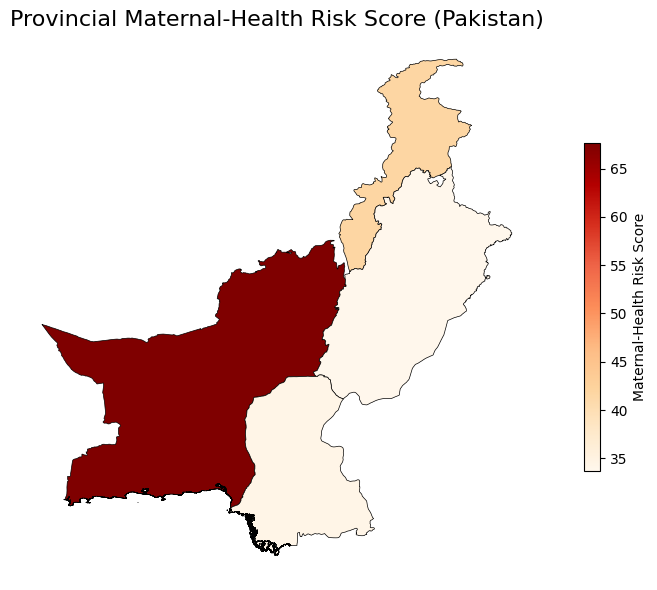

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(
    column='Risk_Score',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Maternal‑Health Risk Score", 'shrink': 0.6},
    ax=ax
)
ax.set_title('Provincial Maternal‑Health Risk Score (Pakistan)', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.savefig('static_prov_risk_choropleth.png', dpi=300)
plt.show()


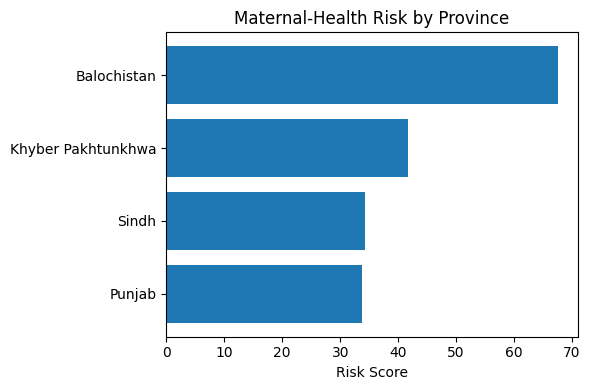

In [8]:
# Sort provinces by descending Risk Score
top4 = merged.sort_values('Risk_Score', ascending=False)

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(top4['Province'], top4['Risk_Score'])
ax.invert_yaxis()
ax.set_xlabel('Risk Score')
ax.set_title('Maternal‑Health Risk by Province')
plt.tight_layout()
plt.savefig('static_prov_top5_bar.png', dpi=300)
plt.show()


In [9]:
# ─────────────────────────────────────────────────────────────────────────────
# Single cell: Generate a detailed research-style HTML report (static choropleth)
# ─────────────────────────────────────────────────────────────────────────────

import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# 1. Load & Clean Data
prov_df = pd.read_csv('prov_pdhs_maternal_health.csv')
prov_df['Province'] = (
    prov_df['Province']
     .str.replace(r'[-–—]', ' ', regex=True)
     .str.strip()
)

gdf = gpd.read_file('gadm41_PAK_shp/gadm41_PAK_1.shp')
gdf = gdf.rename(columns={'NAME_1': 'Province'})
gdf['Province'] = (
    gdf['Province']
     .str.replace(r'[-–—]', ' ', regex=True)
     .str.strip()
)

merged = gdf.merge(prov_df, on='Province', how='inner')

# 2. Define Indicators & Risk Formula
indicators = {
    'ANC (≥4 visits) %':    'ANC_coverage (%)',
    'SBA coverage %':       'SBA_coverage (%)',
    'Facility density':     'Facility_density',
    'Maternal-Health Risk': 'Risk_Score'
}
risk_formula = "Risk Score = 100 – (ANC coverage + SBA coverage) / 2"

# 3. Generate static barh PNG for each indicator
static_pngs = {}
for label, col in indicators.items():
    safe_key = (
        label
        .replace(' ', '_')
        .replace('(≥4_visits)', 'anc')
        .replace('%', '')
        .lower()
    )
    fn = f"static_{safe_key}_bar.png"
    df_s = merged.sort_values(col, ascending=False)
    plt.figure(figsize=(8,4))
    df_s.set_index('Province')[col].plot.barh()
    plt.title(label)
    plt.xlabel(col)
    plt.tight_layout()
    plt.savefig(fn, dpi=150)
    plt.close()
    static_pngs[label] = fn

# 4. Build & save a static Pakistan choropleth of Risk Score
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
merged.plot(
    column='Risk_Score',
    cmap='OrRd',
    linewidth=0.4,
    edgecolor='gray',
    legend=True,
    legend_kwds={'label': "Maternal‑Health Risk", 'shrink': 0.6},
    ax=ax
)
ax.set_title("Provincial Maternal‑Health Risk, Pakistan", fontsize=14)
ax.set_axis_off()

static_map = 'static_pakistan_risk_map.png'
plt.savefig(static_map, dpi=150, bbox_inches='tight')
plt.close()

# 5. Compute Key Findings
sr = merged[['Province','Risk_Score']].sort_values('Risk_Score', ascending=False)
high, low = sr.iloc[0], sr.iloc[-1]
findings = (
    f"<p><strong>Key Findings:</strong> Among Pakistan’s provinces, "
    f"<em>{high.Province}</em> has the highest maternal-health risk "
    f"(Risk Score = {high.Risk_Score:.1f}), followed by "
    f"<em>{sr.iloc[1].Province}</em>. The lowest risk is in "
    f"<em>{low.Province}</em> (Risk Score = {low.Risk_Score:.1f}).</p>"
)

# 6. Compose full HTML
html = f"""
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Detailed Maternal‑Health Research Report</title>
  <style>
    body {{ font-family: 'Times New Roman', serif; margin: 40px auto; max-width: 900px; }}
    h1 {{ text-align: center; font-size: 2.2em; }}
    h2 {{ margin-top: 1.8em; font-size: 1.5em; border-bottom: 1px solid #ccc; padding-bottom: 0.2em; }}
    p, ol {{ line-height: 1.5; }}
    code {{ background: #f4f4f4; padding: 2px 4px; }}
    select {{ display: block; margin: 10px auto; }}
    img {{ display: block; margin: 10px auto; max-width: 100%; }}
    figure {{ margin: 20px 0; text-align: center; }}
    figcaption {{ font-size: 0.9em; color: #555; }}
    footer {{ margin-top: 2em; font-size: 0.8em; color: #555; text-align: center; border-top: 1px solid #ccc; padding-top: 1em; }}
  </style>
</head>
<body>

  <h1>Provincial Maternal‑Health Risk Analysis for Pakistan</h1>

  <h2>Introduction</h2>
  <p>Maternal mortality and morbidity remain major challenges in Pakistan. This report examines provincial disparities in antenatal care (ANC) and skilled birth attendance (SBA) using PDHS 2017–18 data, and constructs a composite <em>Risk Score</em> to highlight areas requiring targeted intervention.</p>

  <h2>Data & Methods</h2>
  <ol>
    <li>Loaded <code>prov_pdhs_maternal_health.csv</code> and cleaned province names.</li>
    <li>Merged with GADM v4.1 Admin‑1 shapefile.</li>
    <li>Computed <em>Risk Score</em> via: <code>{risk_formula}</code>.</li>
    <li>Generated static bar charts and a static choropleth map.</li>
  </ol>

  <h2>Static Bar Charts</h2>
  <label for="staticSelect">Select indicator:</label>
  <select id="staticSelect" onchange="switchBarChart()">
    {"".join(f"<option value='{fn}'>{lbl}</option>" for lbl, fn in static_pngs.items())}
  </select>
  <img id="barChartImage" src="{static_pngs['Maternal-Health Risk']}" alt="Indicator bar chart" />

  <h2>Static Choropleth Map</h2>
  <figure>
    <img src="{static_map}" alt="Pakistan Maternal-Health Risk map" />
    <figcaption>Maternal‑Health Risk Score by province</figcaption>
  </figure>

  <h2>Conclusion & Key Findings</h2>
  {findings}

  <footer>
    Data sources: Pakistan DHS 2017–18; GADM v4.1.<br>
    Report generated via Python, GeoPandas, Matplotlib.
  </footer>

  <script>
    function switchBarChart() {{
      document.getElementById('barChartImage').src =
        document.getElementById('staticSelect').value;
    }}
  </script>

</body>
</html>
"""

# 7. Write out the HTML file
output_file = 'provincial_research_report.html'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write(html)

# 8. Display link for convenience
display(HTML(f"<p>✅ Generated <a href='{output_file}' target='_blank'>{output_file}</a></p>"))
